In [1]:
import pandas
import pyreadr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
transaction = pyreadr.read_r("/data/IDEA_DeFi_Research/Data/Lending_Protocols/Aave/V2/Mainnet/transactions.rds")
df = transaction[None]
df['DateTime'] = df['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
df.head()

,id,type,timestamp,user,userAlias,onBehalfOf,onBehalfOfAlias,pool,reserve,amount,...,priceInUsd,borrowRateModeTo,borrowRateModeFrom,stableBorrowRate,variableBorrowRate,target,totalFee,version,deployment,DateTime
0,0xc70f4c3f447f6a88e9fbb87ac1394b589e469ee57dda...,borrow,1.606841e+09,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Rocky Kuebler,0xbd723fc4f1d737dcfc48a07fe7336766d34cad5f,Rocky Kuebler,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-01 11:46:58
1,0x1ee3db904548c16d2ed3572f3d9894652e031facc8fa...,borrow,1.606902e+09,0x21d05071ca08593e13cd3afd0b4869537e015c92,Odaly Chihuahua-Tovar,0x21d05071ca08593e13cd3afd0b4869537e015c92,Odaly Chihuahua-Tovar,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 04:34:18
2,0x1e8f85330edc5005ead7a7ae8c418fbb64df726d4ffc...,borrow,1.606905e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,LINK,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 05:24:50
3,0x43136c7aba13c072bb19ed88f8eadf859f0bfb994b42...,borrow,1.606913e+09,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0x39d637737cc76c5849a52c7d3b872a1eb22aa71c,Stephon Wal,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,AAVE,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 07:47:21
4,0xd96af0cf05a1e99125fe51ee7e27a1c96cf40ea6e596...,borrow,1.606915e+09,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Jalen Mitchell,0xdad4c11e8cc6a5c37808d3b31b3b284809f702d1,Jalen Mitchell,0xb53c1a33016b2dc2ff3653530bff1848a515c8c5,DAI,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,Mainnet,2020-12-02 08:10:19


In [3]:
# We are going to make a super basic linear model to try and predict how the AAVE token's price changes each day.
# This script will engineer one feature to use for this predictive task: dailyTransactionCount.

# To do this, we group the data by the date portion of the DateTime object, 
# and then simply count how many transactions are in each group
dailyTransactionCount = df.groupby([df['DateTime'].dt.date]).count()
dailyTransactionCount = dailyTransactionCount[['id']]
dailyTransactionCount.rename(columns={"id": "transactionCount"}, inplace = True)
print(dailyTransactionCount)

            transactionCount
DateTime                    
2020-11-30                 3
2020-12-01                20
2020-12-02               205
2020-12-03              1089
2020-12-04               869
...                      ...
2023-11-26               400
2023-11-27               335
2023-11-28               438
2023-11-29               355
2023-11-30               127

[1091 rows x 1 columns]


In [4]:
# We load the minutely Aave price data here:
aavePrices = pandas.read_csv('/data/IDEA_DeFi_Research/Data/Coin_Prices/Minutely/aavePrices.csv')
# And here, since we want to predict daily prices, we create a new features which is the mean daily price.
aavePrices['DateTime'] = aavePrices['timestamp'].transform(lambda x: datetime.fromtimestamp(x))
dailyMeanPrices = aavePrices.groupby([df['DateTime'].dt.date]).mean()
dailyMeanPrices = dailyMeanPrices[['priceUSD']]
print(dailyMeanPrices)

              priceUSD
DateTime              
2020-11-30  160.040985
2020-12-01  189.916972
2020-12-02  165.751269
2020-12-03  189.176691
2020-12-04  207.015268
...                ...
2023-11-26  119.630025
2023-11-27  116.143040
2023-11-28  118.810638
2023-11-29  125.494667
2023-11-30  113.503231

[1090 rows x 1 columns]


In [5]:
dailyTransactionCount = dailyTransactionCount.merge(dailyMeanPrices, left_index = True, right_index = True)
print(dailyTransactionCount)

            transactionCount    priceUSD
DateTime                                
2020-11-30                 3  160.040985
2020-12-01                20  189.916972
2020-12-02               205  165.751269
2020-12-03              1089  189.176691
2020-12-04               869  207.015268
...                      ...         ...
2023-11-26               400  119.630025
2023-11-27               335  116.143040
2023-11-28               438  118.810638
2023-11-29               355  125.494667
2023-11-30               127  113.503231

[1090 rows x 2 columns]


In [6]:
def data_split(data_set):
    from sklearn.model_selection import TimeSeriesSplit
    # We want to use the transactionCount to predict the next day's price. To do this, we "lead" the priceUSD
    # column so in a given row, the transaction count is aligned with the next day's price.
    data_set['priceUSD_lead_1'] = data_set['priceUSD'].shift(-1)
    # We need to drop NA values. One NA value is introduced through this "lead" on the last day in the dataset.
    data_set.dropna(inplace=True)
    # In practice, it is better to predict daily percent price changes rather than predicting literal prices, so we compute the daily
    # percent change here by subtraction tomorrow's price from today's and dividing by today's price.
    data_set['dailyPercentChange'] = (data_set['priceUSD_lead_1'] - data_set['priceUSD']) / data_set['priceUSD']
    tss = TimeSeriesSplit(n_splits = 3)
    X = data_set.drop(labels=['priceUSD_lead_1', 'dailyPercentChange'],axis=1)
    y = data_set['dailyPercentChange']
    for train_index, test_index in tss.split(data_set):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return [X_train, X_test, y_train, y_test]

In [7]:
def linear_regression_model(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import LinearRegression
    # We fit a linear model with the train data, where X_train is our feature matrix and y_train is our target variable
    # using LinearRegression to classify the data
    estimator = LinearRegression()
    fit = estimator.fit(X_train, y_train)
    # We compute the predictions for the X_test features:
    predictions = fit.predict(X_test)
    # The line below just computes the average accuracy of our predictions:
    np.linalg.norm(predictions - y_test) / len(y_test)
    # This for-loop is super ugly and represents my inexperience with Python. All it is intended to do is get
    # the literal y_test values without the associated datetimes, for plotting purposes.
    y_test_vals = list()
    for i in y_test:
        y_test_vals.append(i)
    return predictions, y_test_vals

In [8]:
def plot_ground_truth(predictions, y_test_vals):
    # We plot the ground-truth values in blue and the predicted values in red:
    plt.plot(y_test_vals, color = "blue")
    plt.plot(predictions, color = "red")

In [9]:
def plot_difference(predictions, y_test_vals):
    # We plot the difference between our model's predictions and the actual values:
    plt.plot(y_test_vals - predictions)

In [10]:
'''
train_set[0] = X_train
train_set[1] = X_test
train_set[2] = y_train
train_set[3] = y_test
'''
train_set = list()
train_set = data_split(dailyTransactionCount) # store all 4 types of data inside
# using the linear_regression_model to make prediction
predictions, y_test_vals = linear_regression_model(train_set[0], train_set[1], train_set[2], train_set[3])

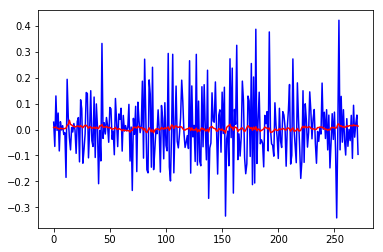

In [11]:
plot_ground_truth(predictions, y_test_vals)

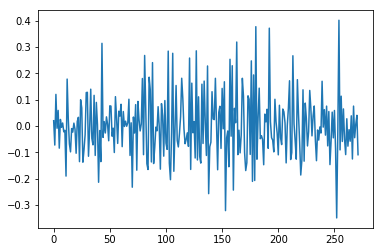

In [12]:
plot_difference(predictions, y_test_vals)

In [13]:
def k_neighbors_classifier(X_train, X_test, y_train, y_test):
    from sklearn.neighbors import KNeighborsClassifier
    # using KNN to classify the data
    estimator = KNeighborsClassifier()
    fit = estimator.fit(X_train, y_train)
    predictions = fit.predict(X_test)
    np.linalg.norm(predictions - y_test) / len(y_test)
    y_test_vals = list()
    for i in y_test:
        y_test_vals.append(i)
#     # evaluate the KNN model
#     # method1: compare the real result and predict result
#     y_predict = estimator.predict(X_test)
#     print("y_predict:\n", y_predict)
#     print("compare real result and predict result:\n", y_test == y_predict)
    
#     # method2: calculate the accuracy
#     accuracy = estimator.score(X_test, y_test)
#     print("accuracy: {0:.2f}\n".format(accuracy * 100))
    return predictions, y_test_vals

In [14]:
# using the k_neighbors_classifier to make prediction
predictions, y_test_vals = k_neighbors_classifier(train_set[0], train_set[1], train_set[2], train_set[3])
plot_ground_truth(predictions, y_test_vals)

ValueError: Unknown label type: 'continuous'

In [ ]:
plot_difference(predictions, y_test_vals)